<a href="https://colab.research.google.com/github/Finweto/cas_etude_1/blob/main/cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN

This noteBook was inspired by an example of cycleGAN from tensorflow. We use preprocessing methods used in their example but the purpose of the model is different. Here we will try to turn photo to paintings of Monet !

## Set up the input pipeline

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-2li__0r6
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-2li__0r6
  Resolved https://github.com/tensorflow/examples.git to commit a71f7e38b0ce56e9f39d8049e836ea8f7af74f83
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a71f7e38b0ce56e9f39d8049e836ea8f7af74f83_-py3-none-any.whl size=299718 sha256=b248329c9bbc2c99665872dc157ba879b6dff43a422282dc3ca286cc8a1027c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-npnjg9gn/wheels/4e/f5/c2/bfe75b834c9028b2529023bf74541c46ead531b513a8010d21
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel c

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import math
import numpy as np
import gc
import random

AUTOTUNE = tf.data.AUTOTUNE

## Input Pipeline

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e. left to right.

In [ ]:
!git clone -b main https://github.com/Finweto/cas_etude_1.git

Cloning into 'cas_etude_1'...
remote: Enumerating objects: 7377, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 7377 (delta 4), reused 5 (delta 0), pack-reused 7359
Receiving objects: 100% (7377/7377), 374.47 MiB | 16.27 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (7367/7367), done.


In [ ]:
directoryPath = '/content/cas_etude_1'
MONET_FILENAMES = tf.io.gfile.glob(str(directoryPath + '/monet_jpg/*.jpg'))
print('Monet JPG Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(directoryPath + '/photo_jpg/*.jpg'))
print('Photo JPG Files:', len(PHOTO_FILENAMES))

PHOTO_FILENAMES = random.sample(PHOTO_FILENAMES,2700)

print('Photo JPG Files:', len(PHOTO_FILENAMES))

Monet JPG Files: 300
Photo JPG Files: 7038
Photo JPG Files: 2700


In [ ]:
def make_dataset(url_list):
  dataset = []
  for url in url_list:
    dataset.append(cv2.cvtColor(cv2.imread(url),cv2.COLOR_BGR2RGB))

  return dataset


'def resize_images(dataset,dim):\n  for i in range(len(dataset)):\n    dataset[i] = (tf.cast(dataset[i], tf.float32) / 127.5) - 1\n    dataset[i] = tf.reshape(dataset[i], [*dim,3])\n    \n\n  return dataset'

# Creation of datasets

In [ ]:
IMAGE_DIM = [256, 256]

dataset_monet = make_dataset(MONET_FILENAMES)

dataset_photo = make_dataset(PHOTO_FILENAMES)


In [ ]:
monet_train = dataset_monet[:math.floor(len(dataset_monet)*0.7)]
monet_test = dataset_monet[math.floor(len(dataset_monet)*0.7):]

photo_train = dataset_photo[:math.floor(len(dataset_photo)*0.7)]
photo_test = dataset_photo[math.floor(len(dataset_photo)*0.7):]

print(len(monet_train),len(monet_test))
print(len(photo_train),len(photo_test))

210 90
1889 811


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

# Data Augmentation

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image):
  image = normalize(image)
  return image

In [ ]:
for i in range(len(monet_train)):
  monet_train[i] = preprocess_image_train(monet_train[i])

for i in range(len(photo_train)):
  photo_train[i] = preprocess_image_train(photo_train[i])

for i in range(len(monet_test)):
  monet_test[i] = preprocess_image_test(monet_test[i])

for i in range(len(photo_test)):
  photo_test[i] = preprocess_image_test(photo_test[i])


In [ ]:
monet_train = tf.data.Dataset.from_tensor_slices(monet_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
photo_train = tf.data.Dataset.from_tensor_slices(photo_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
monet_test = tf.data.Dataset.from_tensor_slices(monet_test).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
photo_test = tf.data.Dataset.from_tensor_slices(photo_test).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

gc.collect()

0

In [ ]:
sample_monet = next(iter(monet_train))
sample_photo = next(iter(photo_train))

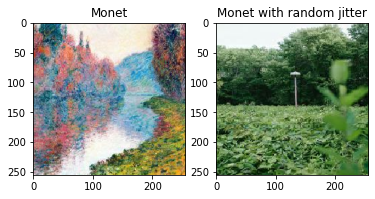

In [ ]:
plt.subplot(121)
plt.title('Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

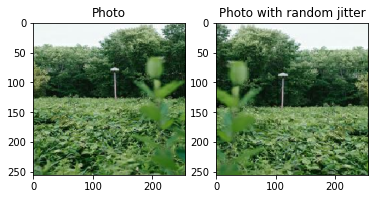

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Photo with random jitter')
plt.imshow(random_jitter(sample_photo[0]) * 0.5 + 0.5)

## Import and reuse the Pix2Pix models

Import the generator and the discriminator used in [Pix2Pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) via the installed [tensorflow_examples](https://github.com/tensorflow/examples) package.

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [ ]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

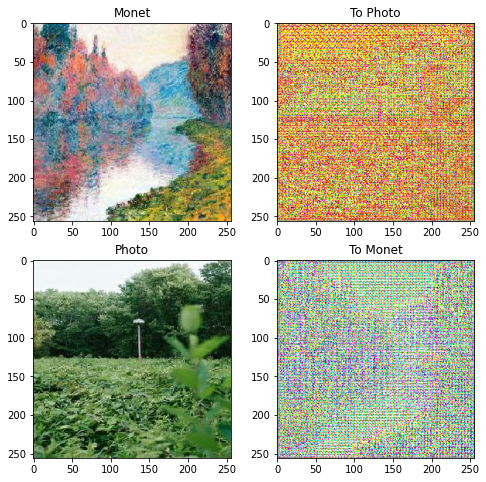

In [ ]:
to_monet = generator_g(sample_monet)
to_photo = generator_f(sample_photo)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_monet, to_photo, sample_photo, to_monet]
title = ['Monet', 'To Photo', 'Photo', 'To Monet']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

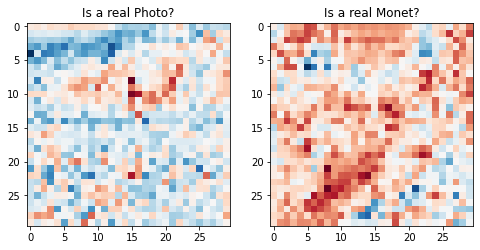

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real Photo?')
plt.imshow(discriminator_y(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Monet?')
plt.imshow(discriminator_x(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss, 

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoints 
Not used in training because of RAM limitations

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

## Training

Good luck finding how much epoch google can let you have 😞
We had one sucessfull run at 200 epochs that lasted 5/6 hours ⏲

In [ ]:
EPOCHS = 100

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # tab of losses
  losses = dict()

  tab_total_gen_g_loss = []
  tab_total_gen_f_loss = []
  tab_disc_x_loss = []
  tab_disc_y_loss = []

  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # memorize losses
    tab_total_gen_g_loss.append(total_gen_g_loss)
    tab_total_gen_f_loss.append(total_gen_f_loss)
    tab_disc_x_loss.append(disc_x_loss)
    tab_disc_y_loss.append(disc_y_loss)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

  losses['gen_g_losses'] = tab_total_gen_g_loss
  losses['gen_f_losses'] = tab_total_gen_f_loss
  losses['disc_x_losses'] = tab_disc_x_loss
  losses['disc_y_losses'] = tab_disc_y_loss

  return losses

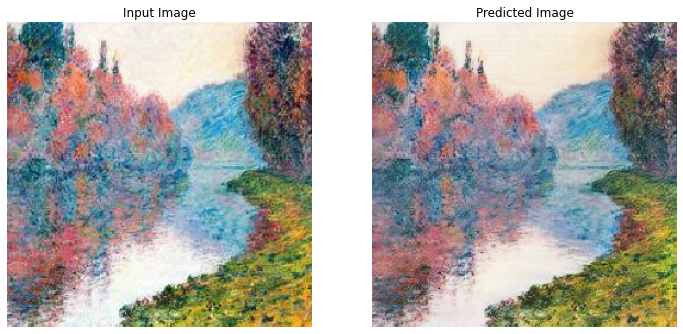

Time taken for epoch 100 is 94.33363318443298 sec



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
losses = []

for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((monet_train, photo_train)):
    losses.append(train_step(image_x, image_y))
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_f, sample_photo)
  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
'''
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
'''

In [ ]:
print(losses)

{}


## Generate using test dataset

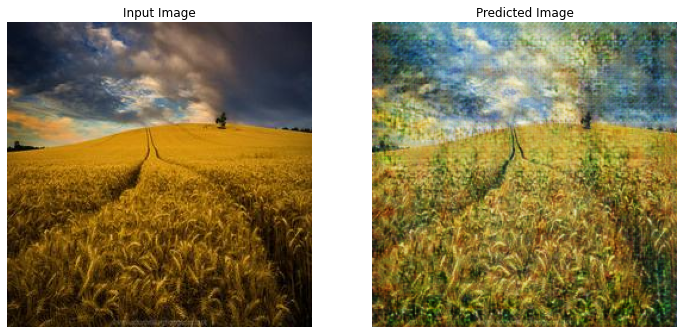

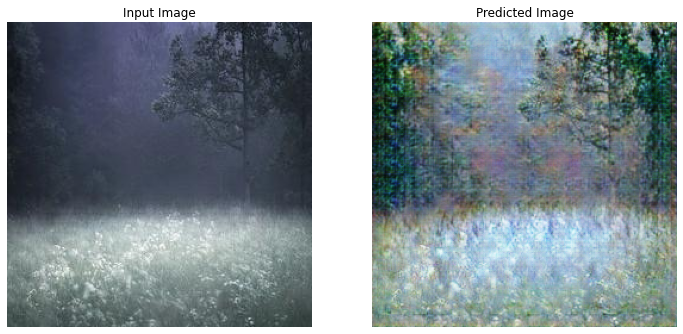

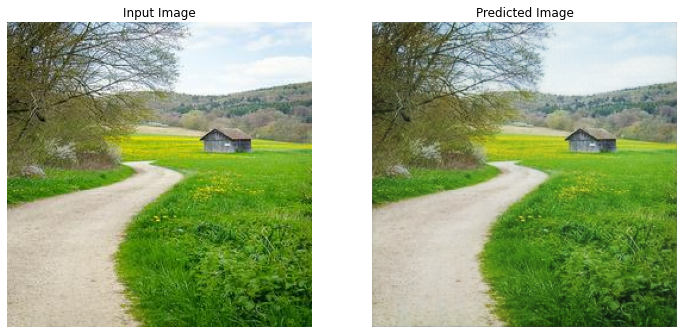

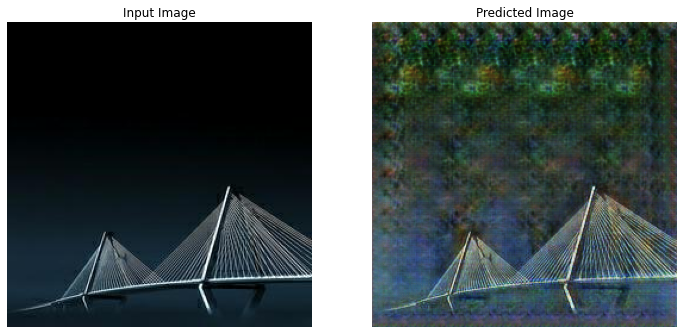

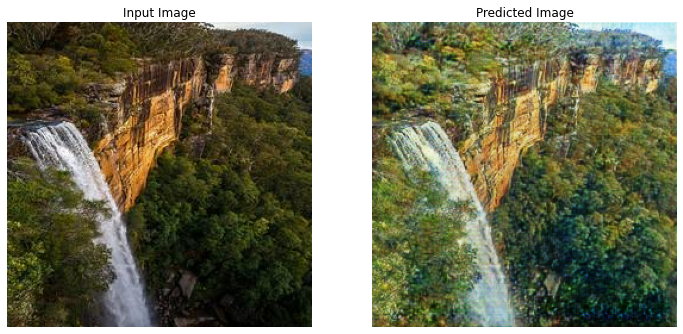

In [ ]:
# Run the trained model on the test dataset

for inp in photo_test.take(5):
  generate_images(generator_f, inp)

# Saving of generator photo --> Monnet

In [ ]:
# création d'un dossier sauvegarde de modèle
!mkdir -p saved_model

# sauvegarde de notre generator_f (photo --> peinture Monet)
generator_f.save('saved_model/generator_photoToMonet')

!zip -r /content/saved_model.zip /content/saved_model

from google.colab import files
files.download('/content/saved_model.zip')

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/generator_photoToMonet/ (stored 0%)
  adding: content/saved_model/generator_photoToMonet/variables/ (stored 0%)
  adding: content/saved_model/generator_photoToMonet/variables/variables.index (deflated 68%)
  adding: content/saved_model/generator_photoToMonet/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/saved_model/generator_photoToMonet/keras_metadata.pb (deflated 95%)
  adding: content/saved_model/generator_photoToMonet/assets/ (stored 0%)
  adding: content/saved_model/generator_photoToMonet/saved_model.pb (deflated 92%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Example of loading of saved model
This part is what you will find in our second file `Test_models_1` more clearly

In [ ]:
# Loading of the saved Model
generator_photoToMonet = tf.keras.models.load_model('/content/saved_model/generator_photoToMonet')
generator_photoToMonet.compile()


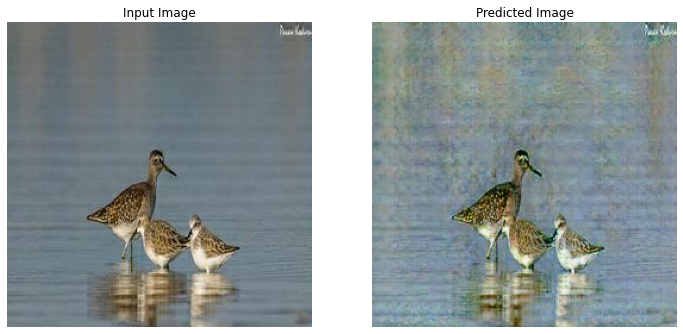

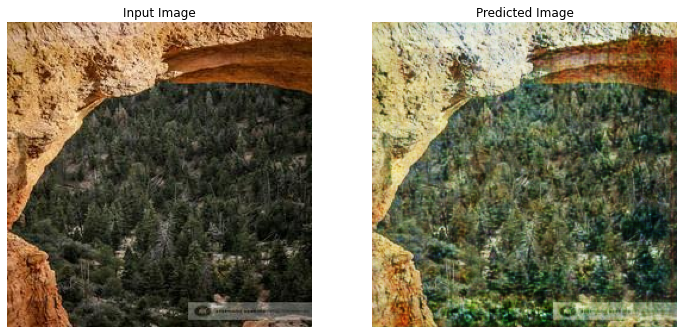

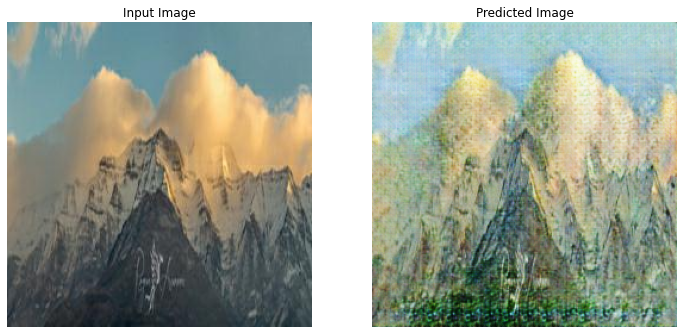

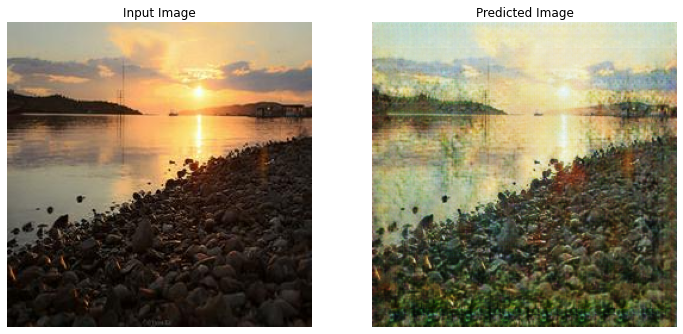

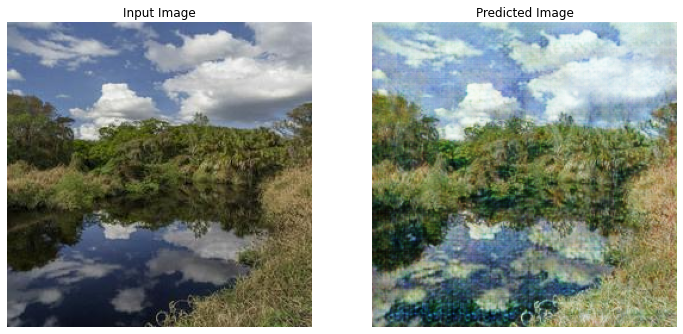

In [ ]:
# Function to display generated images
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

# We display generated images
for inp in photo_test.take(5):
  generate_images(generator_photoToMonet, inp)